# Exercise 3: Multiple walkers metadynamics

In the two previous two examples, the simulations we ran in parallel are indepdent of each other and can therefore be performed separately if wanted. This is different from methods such as multiple walkers metadynamics or replica exchange, where multiple simulations interact with each other and must be performed in parallel.

In this exercise, we will run 4 walkers of metadynamics for the NaCl system, from which we can estimate the free energy surface as a function of ion-pair distance as metadynamics we did in the tutorials on Tuesday. To compare with the results obtained from umbrella sampling in the previous exercise, we will perform the simulations in the NVT ensemble, which was also adopted in the previous tutorial on umbrella sampling. Importantly, multiple walkers metadynamics can be either MPI-based or file-based, as we will elaborate. Below let's first remove the outputs of the exercise if there is any.

In [1]:
%%bash
# Here we remove the output of the exercise if there is any.
dirs=(file_based mpi_based)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

Also, we define the PLUMED binary and a function that helps us run PLUMED commands.

In [2]:
import subprocess
plumed_bin="singularity exec /ocean/projects/see220002p/shared/icomse_cpu.sif plumed"

def run_plumed_cmd(cmd,verbose=False):
    cmd_str="{} ".format(plumed_bin)+cmd
    print("PLUMED command: {}".format(cmd_str))
    if verbose:
        subprocess.run(cmd_str.split())
    else:
        subprocess.run(cmd_str.split(),stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

## 3-1. MPI-based multiple walkers metadynamics

To run 4 walkers of metadynamics that communicate with each other via MPI, we the following:
- **Step 1**: Create folders named as `walker_0`, `walker_1`, `walker_2`, `walker_3`. 
- **Step 2**: In each folder, copy over the input files and generate a `tpr` file. 
- **Step 3**: In each folder, create a PLUMED input file `plumed.dat`. PLUMED input files across walkers should be the same.
- **Step 4**: Outside the folder, run the GROMACS `mdrun` command.

In [3]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

mkdir mpi_based && cd mpi_based
for i in {0..3}
do
    mkdir walker_${i} && cd walker_${i}
    cp ../../../Inputs/NaCl/NaCl* .       # This include the gro and top file
    cp ../../../Inputs/NaCl/MD-NVT.mdp .  # The mdp file for running NVT simulations
    mpirun -np 1 gmx_mpi grompp -f MD-NVT.mdp -c NaCl.gro -p NaCl.top -o multi_metad.tpr
    cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -996449022
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "The greatest shortcoming of the human race is our inability to understand the exponential function." (Albert Bartlett)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -468980050
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "If a rat is a good model for your emotional life, you're in big trouble." (Robert Sapolsky)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karko

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1653209620
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "The programmer got stuck in the shower because the instructions on the shampoo bottle said: Lather, Rinse, Repeat." (Anonymous)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghan

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Setting gen_seed to 1167253587
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "All Beauty Must Die" (Nick Cave)



In [4]:
%%bash
cd mpi_based
for i in {0..3}
do 
cd walker_${i}
echo '# Distance between Na and Cl atoms
dist: DISTANCE ATOMS=322,323

uwall: UPPER_WALLS ...
   ARG=dist 
   AT=0.6
   KAPPA=4000.0 
...

METAD ...
  LABEL=mtd
  ARG=dist
  PACE=500
  SIGMA=0.02 
  HEIGHT=1.25
  BIASFACTOR=5
  GRID_MIN=0.0
  GRID_MAX=1.0
  CALC_RCT
  FILE=hills.data
  WALKERS_DIR=../
  WALKERS_MPI
... METAD

PRINT ARG=dist,mtd.*,uwall.* FILE=colvar.data STRIDE=250
' > plumed.dat
cd ../
done

In [5]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

cd mpi_based
mpirun -np 4 gmx_mpi mdrun -s multi_metad.tpr -plumed plumed.dat -multidir walker_{0..3} -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

CPU times: user 48.8 ms, sys: 10.6 ms, total: 59.3 ms
Wall time: 38.1 s


As a result, `colvar.0.dat`, `colvar.1.dat`, `colvar.2.dat` and `colvar.3.dat` were generated in foldes `walker_0`, `walker_1`, `walker_2`, and `walker_3`, respectively. Each of them kept track of the collective variable for each walker, from which we can visualize below.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

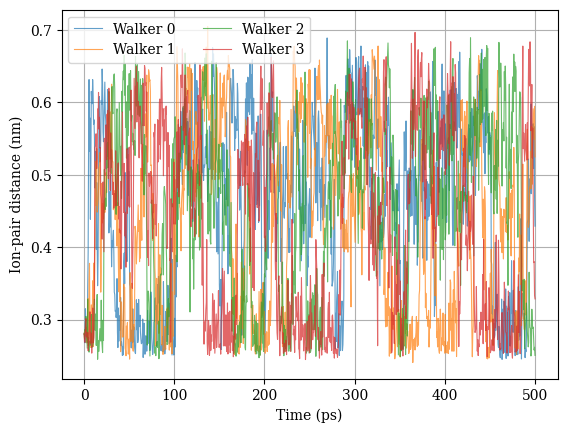

In [7]:
plt.figure()
for i in range(4):
    dist = np.transpose(np.loadtxt(f'mpi_based/walker_{i}/colvar.{i}.data'))[1]
    plt.plot(np.arange(len(dist)) * 0.5, dist, alpha=0.7, linewidth=0.8, label=f'Walker {i}')
    plt.xlabel('Time (ps)')
    plt.ylabel('Ion-pair distance (nm)')
plt.legend(ncols=2)
plt.grid()

On the other hand, there will be only one `HILLS` output, which as specified in our PLUMED input file, is one level above the `walkers_*` directory and named as `hills.data`. From this file, we can rescontruct the free energy surface as a function of ion-pair distance using `sum_hills`.

In [8]:
run_plumed_cmd('sum_hills --hills mpi_based/hills.data --outfile mpi_based/fes.dat --mintozero', verbose=True)

PLUMED command: singularity exec /ocean/projects/see220002p/shared/icomse_cpu.sif plumed sum_hills --hills mpi_based/hills.data --outfile mpi_based/fes.dat --mintozero
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.2 (git: Unknown) compiled on Mar 13 2023 at 13:57:47
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /opt/conda/lib/plumed
PLUMED: For installed feature, see /opt/conda/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bu

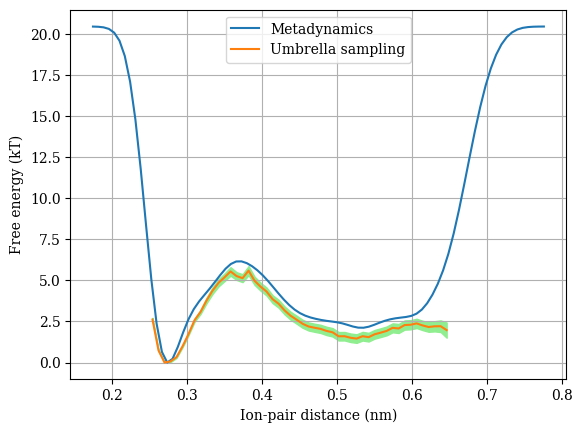

In [14]:
fes_MetaD = np.transpose(np.loadtxt('mpi_based/fes.dat', comments=['@', '#']))
fes_US = np.transpose(np.loadtxt('../Exercise_2/fes.dat', comments=['@', '#']))
kT = 300 * 1.380649E-23 * 6.02214076E23 / 1000   # 1 kT in kJ/mol
plt.figure()
plt.plot(fes_MetaD[0], fes_MetaD[1] / kT, label='Metadynamics')
plt.plot(fes_US[0], fes_US[1], label='Umbrella sampling')
plt.fill_between(fes_US[0], fes_US[1] - fes_US[2], fes_US[1] + fes_US[2], color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.legend()
plt.grid()

## 3-2. File-based multiple walkers metadynamics

To run file-based metadynamics using 4 walkers, we need to prepare 4 folders, with each of them at least having a GROMACS `tpr` file and a PLUMED input file (in the form of `plumed.i.dat` for walker `i`). To set this up, we execute the following commands.

In [ ]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

mkdir file_based && cd file_based
for i in {0..3}
do
    mkdir walker_${i} && cd walker_${i}
    cp ../../../Inputs/NaCl/NaCl* .       # This include the gro and top file
    cp ../../../Inputs/NaCl/MD-NVT.mdp .  # The mdp file for running NVT simulations
    mpirun -np 1 gmx_mpi grompp -f MD-NVT.mdp -c NaCl.gro -p NaCl.top -o multi_metad.tpr
    cd ../
done

As shown below, a file-based multiple walkers metadynamics simulation required additional parameters to be specified in the PLUMED input files, including
- `WALKERS_N`: The number of walkers
- `WALKERS_ID`: The index (starting from 0) of the walker. The value should vary for different walkers. 
- `WALKERS_DIR`: The directory where all the HILLS files from different walkers will be saved.
- `WALKERS_RSTRIDE`: The stride for walkers to read the HILLS file. 

```
# Distance between Na and Cl atoms
dist: DISTANCE ATOMS=322,323

uwall: UPPER_WALLS ...
   ARG=dist 
   AT=0.6
   KAPPA=4000.0 
...

METAD ...
  LABEL=mtd
  ARG=dist
  PACE=500
  SIGMA=0.02 
  HEIGHT=1.25
  BIASFACTOR=5
  GRID_MIN=0.0
  GRID_MAX=1.0
  CALC_RCT
  FILE=hills.data
  WALKERS_N=4
  WALKERS_ID=0
  WALKERS_DIR=./HILLS
  WALKERS_RSTRIDE=100
... METAD

PRINT ARG=dist,mtd.*,uwall.* FILE=colvar.data STRIDE=250
```

In [ ]:
%%bash
cd file_based
for i in {0..3}
do
    cd walker_${i}
    echo '
# Distance between Na and Cl atoms
dist: DISTANCE ATOMS=322,323

uwall: UPPER_WALLS ...
   ARG=dist 
   AT=0.6
   KAPPA=4000.0 
...

METAD ...
  LABEL=mtd
  ARG=dist
  PACE=500
  SIGMA=0.02 
  HEIGHT=1.25
  BIASFACTOR=5
  GRID_MIN=0.0
  GRID_MAX=1.0
  CALC_RCT
  FILE=hills.data
  WALKERS_N=4
  WALKERS_ID='$i'
  WALKERS_DIR=./HILLS
  WALKERS_RSTRIDE=100
... METAD

PRINT ARG=dist,mtd.*,uwall.* FILE=colvar.data STRIDE=250
    ' > plumed.${i}.dat
    cd ../
done

In [ ]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

cd file_based
mpirun -np 4 gmx_mpi mdrun -s multi_metad.tpr -plumed -multidir walker_{0..3} -ntomp 4